In [62]:
import numpy as np
from scipy import ndimage
import matplotlib.image as mpimg
from scipy.ndimage.filters import convolve
import matplotlib.pyplot as plt 

## Step 1: Noise Reduction using Gaussian Filter ##

In [44]:
#Defining the gaussian kernel for noise reduction
def gaussian_kernel(size, sigma=1):
    
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    normal = 1 / (2.0 * np.pi * sigma**2)
    g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
    return g

## Step 2: Sobel Filter for detecting edges using gradient ##

In [45]:
#Creating sobel filter for calculating gradients for each pixel for both x and y. G 
def sobel_filters(img):
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)
    
    Ix = ndimage.filters.convolve(img, Kx)
    Iy = ndimage.filters.convolve(img, Ky)
    
    #Square root of the sum of squares of I_x and I_y is the magnitude of the gradient. Theta is the direction of the edge
    G = np.hypot(Ix, Iy)
    G = G / G.max() * 255
    theta = np.arctan2(Iy, Ix)
    
    return (G, theta)

## Step 3: Non-Maximum Suppression ##

In [46]:
#This step would use the angle and traverse in that direction for each point. If there is a stronger intensity pixel
#in that direction, the selected pixel would be made 0

def non_max_suppression(img, D):
    
    M, N = img.shape
    Z = np.zeros((M,N), dtype=np.int32)
    angle = D * 180. / np.pi
    angle[angle < 0] += 180

    
    for i in range(1,M-1):
        for j in range(1,N-1):
            try:
                q = 255
                r = 255
                
               #angle 0
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = img[i, j+1]
                    r = img[i, j-1]
                #angle 45
                elif (22.5 <= angle[i,j] < 67.5):
                    q = img[i+1, j-1]
                    r = img[i-1, j+1]
                #angle 90
                elif (67.5 <= angle[i,j] < 112.5):
                    q = img[i+1, j]
                    r = img[i-1, j]
                #angle 135
                elif (112.5 <= angle[i,j] < 157.5):
                    q = img[i-1, j-1]
                    r = img[i+1, j+1]

                if (img[i,j] >= q) and (img[i,j] >= r):
                    Z[i,j] = img[i,j]
                else:
                    Z[i,j] = 0

            except IndexError as e:
                pass
    
    return Z

## Step 4: Double Threshold ##

In [81]:
#This step segments edge intensities into Strong, weak and irrelevant basis the lowthreshhold/highthreshold ratio
#Points above strong threshold are kept as is. Points below low threshhold are neglected
#Points between strong and weak are kept and a decision on those are taken in the next step

def threshold(img, lowThresholdRatio=0.05, highThresholdRatio=0.09):
    
    highThreshold = img.max() * highThresholdRatio;
    lowThreshold = highThreshold * lowThresholdRatio;
    
    M, N = img.shape
    res = np.zeros((M,N), dtype=np.int32)
    
    weak = np.int32(25)
    strong = np.int32(255)
    
    strong_i, strong_j = np.where(img >= highThreshold)
    zeros_i, zeros_j = np.where(img < lowThreshold)
    
    weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))
    
    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak
    
    return (res)

## Step 5: Edge Tracking by Hysteresis ##

In [82]:
#Pixels around all weak points are checked. If there is atleast one strong point around a weak point, the weak point
#is accepted and transformed into a strong pixel otherwise it is dropped and reduce to 0
def hysteresis(img, weak=100, strong=255):

    M, N = img.shape  
    for i in range(1, M-1):
        for j in range(1, N-1):
            if (img[i,j] == weak):
                try:
                    if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                        or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                        or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                        img[i, j] = strong
                    else:
                        img[i, j] = 0
                except IndexError as e:
                    pass
    return img

In [84]:
def detect(img,kernel_size,sigma):
    
    img_smoothed = convolve(img,gaussian_kernel(kernel_size, sigma))
    gradientMat, thetaMat = sobel_filters(img_smoothed)
    nonMaxImg = non_max_suppression(gradientMat,thetaMat)
    thresholdImg = threshold(nonMaxImg)
    img_final = hysteresis(thresholdImg) 

    return img_final

In [89]:
def rgb2gray(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray

dir_name='Computer Vision Practice'
filename='tesla.jpg'
img = mpimg.imread(dir_name + '/' + filename)
img = rgb2gray(img)

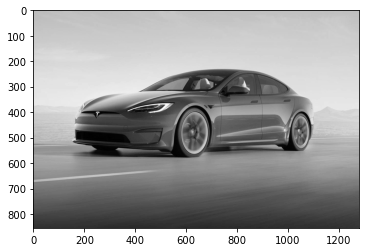

In [90]:
plt.imshow(img,'gray')

In [91]:
edge_image=detect(img,3,1)

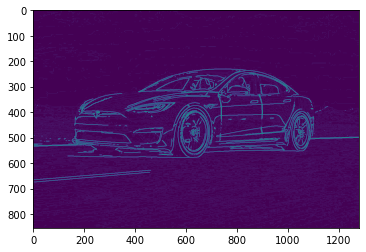

In [92]:
plt.imshow(edge_image)